# Inference 

In [34]:
import os
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()

In [35]:
!set CV_IO_MAX_IMAGE_PIXELS=18500000000

In [36]:
import os 
from mmdet.apis import init_detector, show_result_pyplot
from mmrotate.apis import inference_detector_by_patches
import mmrotate
import torch
print(mmrotate)
mmrotate.__version__=='0.3.4'

<module 'mmrotate' from '/mnt/hdd/eric/.tmp_ipy/00.Reproduction_Test/mmrotate/__init__.py'>


True

In [37]:
checkpoint_file = "/mnt/hdd/eric/.tmp_ipy/00.Checkpoint/ship_tmp_multi_13_S2ANet_Transfer_v2/epoch_56.pth"
config_file = "/mnt/hdd/eric/.tmp_ipy/00.Checkpoint/ship_tmp_multi_13_S2ANet_Transfer_v2/ship_fine_tunning.py"

In [38]:
from mmcv import Config

cfg = Config.fromfile(config_file)

In [39]:
#--------------------------------------
# classes
cfg.model.fam_head.num_classes=13 
cfg.model.odm_head.num_classes=13

classes=(
        'Barge', 'Cargo', 'Container_Ship', 'Dock', 'Fishing_Vessel',
        'Hovercraft', 'Motorboat', 'Oil_Tanker', 'Other_Aircraft_Carrier',
        'RoRo', 'Submarine', 'Warship', 'Yacht'
    )
cfg.data.train.classes=classes
cfg.data.val.classes=classes
cfg.data.test.classes=classes

# batch 
cfg.data.samples_per_gpu = 1

cfg.gpu_ids = [0]
cfg.device='cuda'
cfg.seed=22

# random seed
from mmdet.apis import set_random_seed
set_random_seed(cfg.seed,deterministic=True)

In [40]:
model = init_detector(cfg, checkpoint_file, device='cuda:0')

load checkpoint from local path: /mnt/hdd/eric/.tmp_ipy/00.Checkpoint/ship_tmp_multi_13_S2ANet_Transfer_v2/epoch_56.pth
model to device #-----------------------------# :  cuda:0


In [41]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

sample_img = "/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/C1_20221227015155_09806_00006119_L1G/0-Pusan-2023-AO_1_C1_20221227015155_09806_00006119_L1G.png"
img_ = Image.open(sample_img)

# plt.figure(figsize=(80,80))
# plt.imshow(img_)

# print(img_.size)

In [42]:
#--------------------------------

from easydict import EasyDict
import numpy as np 

args = EasyDict()
args.img = "/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/C1_20221227015155_09806_00006119_L1G/0-Pusan-2023-AO_1_C1_20221227015155_09806_00006119_L1G.png"
args.patch_sizes = [1024,800,2048]
args.patch_steps = [824,672,1920]
args.img_ratios = [1.0,1.5,2.0]

args.merge_iou_thr = 0.5
args.device = 'cuda:0'
args.score_thr = 0.2
args.palette = 'dota'

result = inference_detector_by_patches(model, args.img, args.patch_sizes,
                                        args.patch_steps, args.img_ratios,
                                        args.merge_iou_thr)

# save result 

#np.save("/mnt/hdd/eric/.tmp_ipy/00.Data/tmp_/result_s2a.npy", result)


# show the results
# show_result_pyplot(
#     model,
#     args.img,
#     result,
#     palette=args.palette,
#     score_thr=args.score_thr,
#     out_file=os.path.join("/mnt/hdd/eric/.tmp_ipy/00.Data/tmp_", "2SANet_56-Epochs_0.01-mergeiou.png") )


inference_detector_by_patches GPU ! :  cuda:0


In [43]:
cnt =0 

for cl in result:
    for box in cl:
        cnt+=1
print(cnt)

# args.merge_iou_thr = 0.01 => 417
# args.merge_iou_thr = 0.01 => 445
# args.merge_iou_thr = 0.9  => 1559  

554


In [44]:
# box rotate visual
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import math

# Example usage:
box = [100, 200, 80, 40]

def convert_to_polygon(box):
    x, y, width, height = box

    # Calculate the coordinates of the four corners # => 이거 좌하단 기준인데.. ? 
    # => center 기준으로 update
    x1, y1 = x - (0.5 * width) , y - (0.5 * height)
    x2, y2 = x + (0.5 * width),  y - (0.5 * height)
    x3, y3 = x + (0.5 * width),  y + (0.5 * height)
    x4, y4 = x - (0.5 * width),  y + (0.5 * height)

    # Create a list of points representing the polygon
    polygon = [[x1, y1], [x2, y2],[x3, y3], [x4, y4]]

    return polygon

polygon = convert_to_polygon(box)
print("Polygon:", polygon)

# rotate box 

def rotate_point(point, center, angle_degrees):
    angle_radians = np.radians(angle_degrees)
    x, y = point
    cx, cy = center

    new_x = (x - cx) * np.cos(angle_radians) - (y - cy) * np.sin(angle_radians) + cx
    new_y = (x - cx) * np.sin(angle_radians) + (y - cy) * np.cos(angle_radians) + cy

    return [new_x, new_y]

def rotate_bounding_box(box, center, angle_degrees):
    rotated_box = [rotate_point(point, center, angle_degrees) for point in box]
    return rotated_box

def get_ceter_bounding_box(box):
    polygon= box
    width_center =max( [ i[0] for i in polygon] ) - min( [ i[0] for i in polygon] ) 
    height_center = max( [ i[1] for i in polygon] ) - min( [ i[1] for i in polygon] )
    x_center = min( [ i[0] for i in polygon] )  + 1/2* width_center
    y_center = min( [ i[1] for i in polygon] )  + 1/2* height_center

    return [x_center, y_center]

Polygon: [[60.0, 180.0], [140.0, 180.0], [140.0, 220.0], [60.0, 220.0]]


In [45]:
# box 마다,class 값들을 부여해주기
total_boxes = []
for i,clsses in enumerate(result):
    tmp_boxes = []
    for box in clsses:
        #print("box ", box)
        new_box = np.append(box,int(i))
        #print("new box" , new_box) 
        tmp_boxes.append(new_box)
        
    
    total_boxes.append(tmp_boxes)


# each box convert to polygon
# box_cate = total_boxes[1]

'''
box sample

[polygon(vertices), prob_score] 

[[3293.360749780455, 756.2741447745613],
 [3316.5548281857787, 862.7663898073475],
 [3293.117765844545, 867.8709968270012],
 [3269.9236874392213, 761.378751794215],
 0.06087624281644821]
'''

all_rotated_poly_boxes = []
for box_cate in total_boxes:
    cate_boxes = []
    for box in box_cate:
        # rotate box
        
        # 1. draw box without angle  
        # convert 4type box to polygon 
        tmp_box = [box[0],box[1],box[2],box[3]]
        # poloy box 
        box_poly = convert_to_polygon(tmp_box)
        # angle
        tmp_angle = box[4]
        #print(tmp_angle)
        tmp_angle = tmp_angle*180/np.pi
        #print(tmp_angle)
        tmp_score = box[5]
        tmp_class = box[6]

        # center 
        tmp_center = [box[0],box[1]]
        # rotated_box
        rotated_box_poly = []
        
        # 2. rotate vertices 
        # 3. convert to polyformat 
        for vertice in box_poly:
            rotated_point = rotate_point(vertice, tmp_center, tmp_angle)
            #print(rotated_point)
            rotated_box_poly.append(rotated_point)

        # add score 
        rotated_box_poly.append(tmp_score)
        rotated_box_poly.append(tmp_class)

        # 4. 전체 박스를 하나의 리스트에 담기 위해서. 중간 box 거치지 않고 하나로 
        #cate_boxes.append(rotated_box_poly)
        all_rotated_poly_boxes.append(rotated_box_poly)

    #all_rotated_poly_boxes.append(cate_boxes)
    

In [46]:
all_rotated_poly_boxes[0]

[[5086.441824849701, 1032.8935136207735],
 [5141.576053489699, 1004.1179607132374],
 [5147.138253275299, 1014.7751875511015],
 [5092.004024635301, 1043.5507404586376],
 0.49522116780281067,
 0.0]

# NMS

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as geo_Polygon

In [48]:
#---

boxes = [i[0:4] for i in all_rotated_poly_boxes]
scores = [i[4] for i in all_rotated_poly_boxes]
classes = [i[5] for i in all_rotated_poly_boxes]


#---
iou_thr = 0.05
print("iou_thr : ", iou_thr)


assert len(boxes) == len(scores)

scores = np.array(scores)
order = scores.argsort() # array([0, 3, 2, 1]) 오름차순 

keep = []
keep_idx = set()


while len(order) > 0 :
    
    # extract the index of the prediction with highest score
    idx = order[-1]

    # push S in filtered predictions list
    keep.append(boxes[idx])
    keep_idx.add(int(idx))

    # remove S from P 
    order = order[:-1]
    
    # sanity check
    if len(order) == 0:
        break

    # select coordinates of BBoxes according to the indices in order

    polygon1 = geo_Polygon( boxes[idx] )
    polygons = [ geo_Polygon( boxes[i] ) for i in order] 
    

    unions = [ polygon1.union(p).area for p in polygons]
    intersections = [ polygon1.intersection(p).area for p in polygons]

    ious = [pair[0] /pair[1]  for pair in zip( intersections,unions)]
    #print("ious", ious)
    mask = [i for i, k in enumerate(ious) if k < iou_thr]
    #print(mask)

    order = order[mask]


#--------------------------------- post-processing
# keep_idx 에 있는 indexing을 score 와 class 에 적용
keep_idx = list(keep_idx)    
keep_scores = scores[keep_idx]
classes = np.array(classes)
keep_classes = classes[keep_idx]


tmp_all = []

for i,box in enumerate(keep):
    a1 = box[0]
    a2 = box[1]
    a3 = box[2]
    a4 = box[3] 
    
    score_ = keep_scores[i]
    class_ = keep_classes[i]
    
    tmp_ = [a1,a2,a3,a4,score_,class_]
    tmp_all.append(tmp_)
    
print(len(keep), len(keep_scores), len(keep_classes))

iou_thr :  0.05
122 122 122


(7410, 7220)


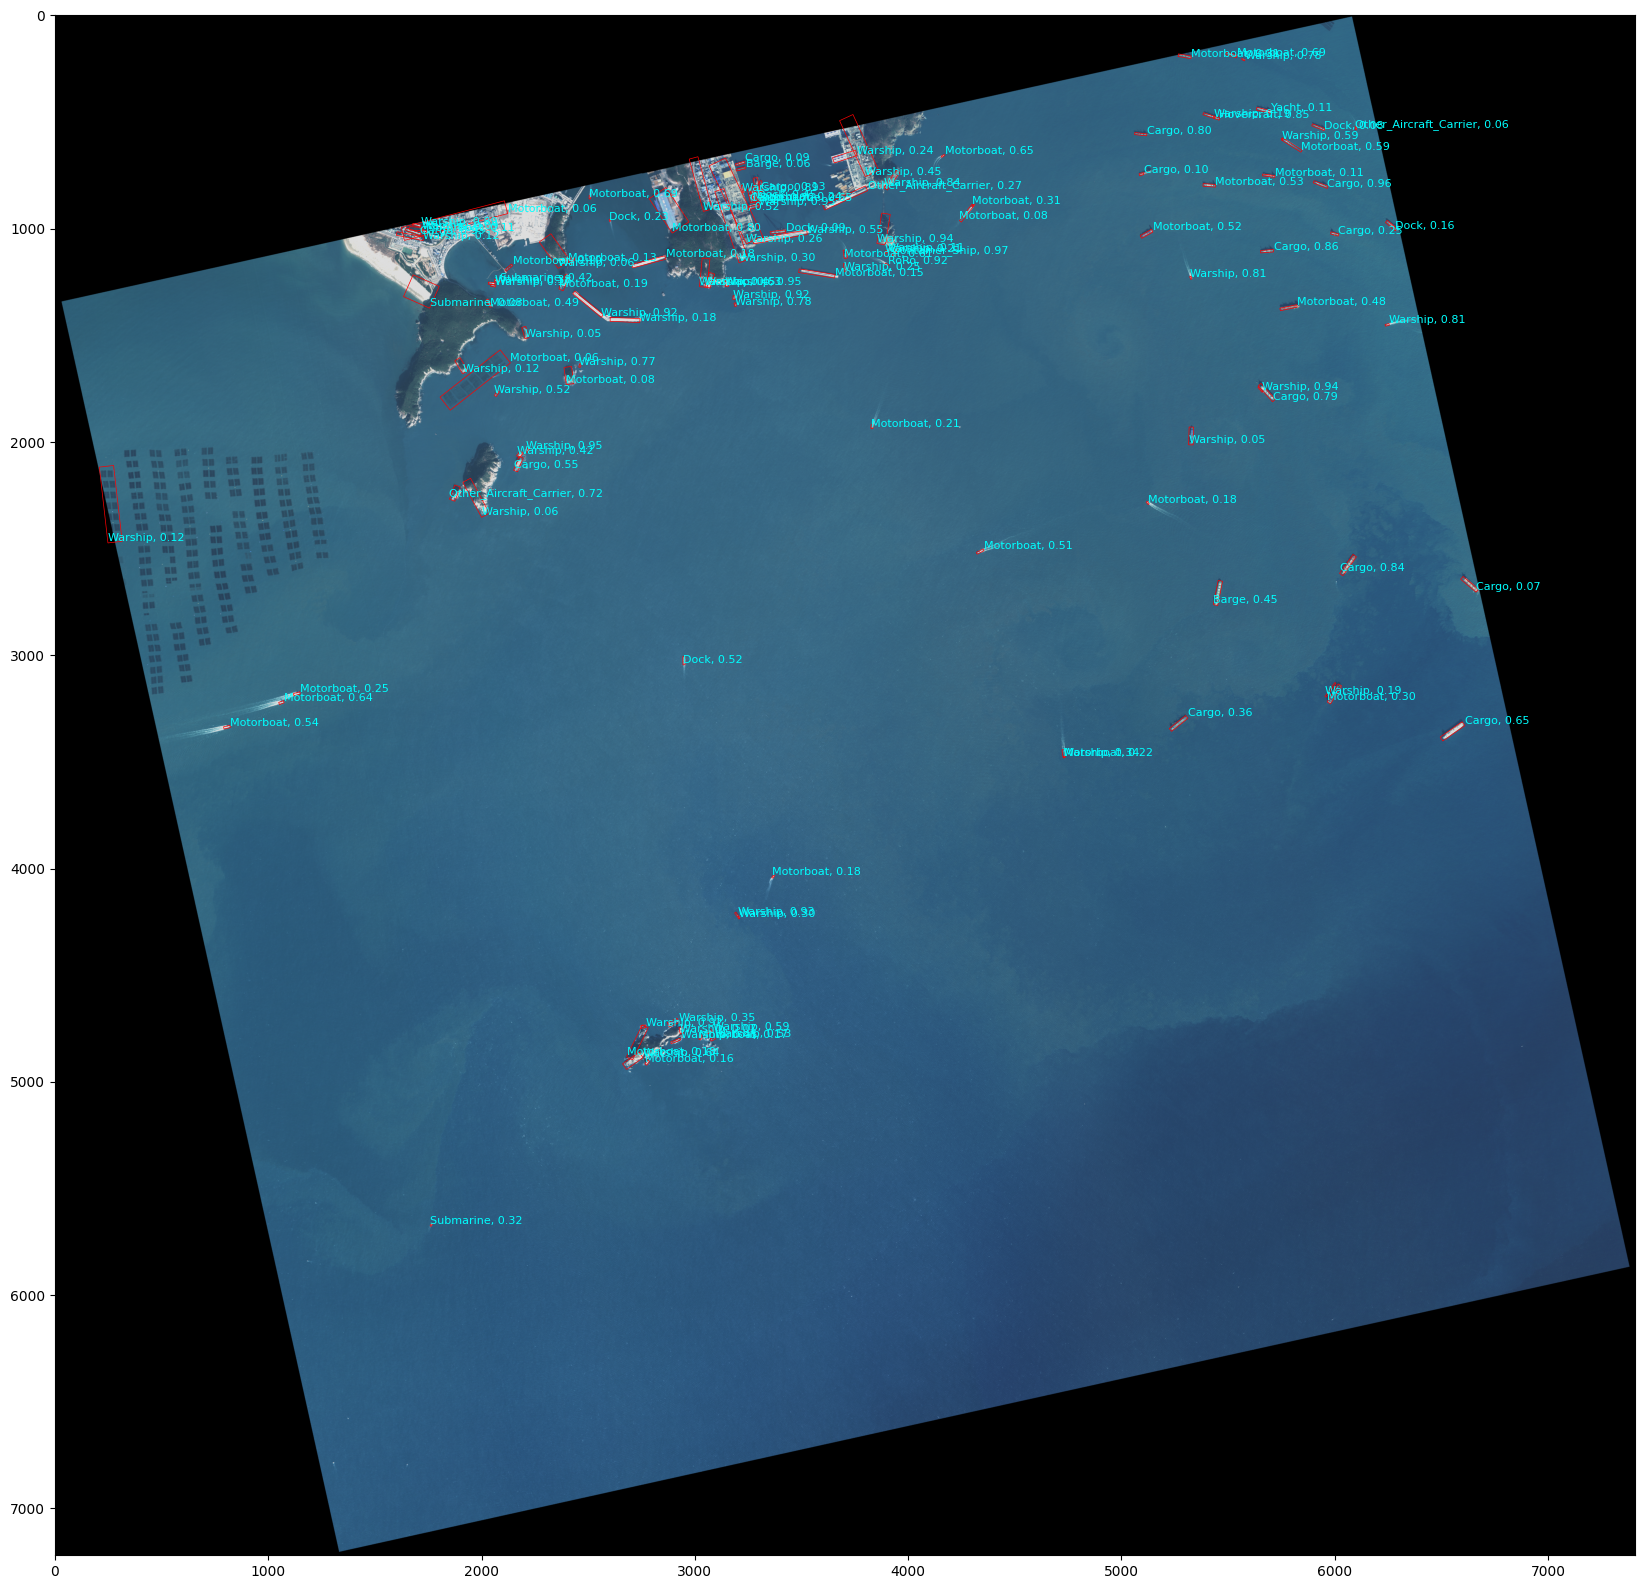

In [49]:
# draw all rotated polygon to the image (before NMS)
import cv2
from PIL import Image
import matplotlib.pyplot as plt

#---------- data
sample_img = "/mnt/hdd/eric/.tmp_ipy/00.Data/AO/0-Pusan-2023-AO/C1_20221227015155_09806_00006119_L1G/0-Pusan-2023-AO_1_C1_20221227015155_09806_00006119_L1G.png"
img_ = Image.open(sample_img)

all_polys = tmp_all

#--------- data
print(img_.size)
# img var 
img_

# Create a figure and axes
fig, ax = plt.subplots(figsize=(40,20))

# Display the image
ax.imshow(img_)

# class map 
class_map=[
        'Barge', 'Cargo', 'Container_Ship', 'Dock', 'Fishing_Vessel',
        'Hovercraft', 'Motorboat', 'Oil_Tanker', 'Other_Aircraft_Carrier',
        'RoRo', 'Submarine', 'Warship', 'Yacht'
]


# Draw each polygon on the image
for polygon_ in all_polys:
    polygon_coords = np.array( polygon_[0:4] )
    polygon_score = np.array( polygon_[4] ) 
    polygon_class = int( np.array( polygon_[5] ) )
    class_str     = class_map[polygon_class]

    #print(polygon_coords)
    polygon = Polygon(polygon_coords,closed=True, edgecolor='r', linewidth=0.5, facecolor='none')
    ax.add_patch(polygon)

    # Add label
    label_text = f"{class_str}, {polygon_score:.2f}"
    label_x, label_y = polygon_coords[2, :2]  # You can adjust the label position based on your requirements
    #ax.text(label_x, label_y, label_text, color='b', fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.7))
    ax.text(label_x, label_y, label_text, color='cyan', fontsize=8, verticalalignment='bottom' )

# Show the plot
plt.savefig(f"/mnt/hdd/eric/.tmp_ipy/00.Data/tmp_/S2ANet_01_1.png",dpi =1200 )
plt.show()